# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом "Не бит, не крашен" разрабатывает новое приложение для привлечения новых клиентов.
Приложение позволит пользователям узнать рыночную стоимость своего автомобиля, используя данные о технических характеристиках, комплектации и ценах других автомобилей. Это поможет клиентам принимать обоснованные решения о продаже своего автомобиля и получать за него справедливую цену.

**Цель проекта**: Построить модель машинного обучения, которая сможет быстро и точно предсказывать рыночную стоимость автомобиля на основе его характеристик.

**Задачи проекта**:
1. Изучить данные о характеристиках автомобилей, выявить аномалии и пропущенные значения.
2. Обработать данные, включая заполнение пропущенных значений и удаление аномалий.
3. Подготовить выборки для обучения моделей, включая разделение данных на тренировочную и тестовую выборки. 
4. Обучить различные модели машинного обучения, включая LightGBM и другие модели, не использующие бустинг.
5. Проанализировать время обучения, время предсказания и качество моделей.
6. Выбрать лучшую модель на основе критериев заказчика, включая качество предсказания, время обучения и время предсказания.
7. Проверить качество выбранной модели на тестовой выборке.

В этом проекте есть критерии, которые важны для заказчика.

**Критерии заказчика:** 
- Качество предсказания.
- Время обучения модели.
- Время предсказания модели.

Кроме того, для оценки качества моделей мы будем использовать метрику RMSE, значение которой должно быть меньше 2500.

**Описание данных:**

Данные находятся в файле /datasets/autos.csv и содержат информацию о различных признаках автомобилей, таких как тип кузова, год регистрации, тип коробки передач, мощность, модель, пробег, тип топлива, марка автомобиля, был ли автомобиль в ремонте. 

Целевым признаком является цена автомобиля в евро.

Более подробно можно ознакомится со списком признаков в датасете здесь:

Признаки:
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет

Целевой признак:
* Price — цена (евро)


Конечный результат проекта заключается в создании эффективной модели машинного обучения, способной точно предсказывать рыночную стоимость автомобиля на основе его характеристик. Модель должна удовлетворять критериям качества предсказания, времени обучения и времени предсказания, установленным заказчиком.


Модель машинного обучения может быть интегрирована в приложение сервиса по продаже автомобилей с пробегом «Не бит, не крашен». Она позволит пользователям получать точную оценку рыночной стоимости своего автомобиля, что поможет им принимать обоснованные решения о продаже и получать справедливую цену.

In [1]:
# обновим библиотеку scikit-learn
!pip install -U scikit-learn

# импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm

# устанавливаем и/или загружаем библиотеку lightgbm
try:
    import lightgbm
except:
    !pip install lightgbm
    import lightgbm
    
# устанавливаем и/или загружаем библиотеку phik
try:
    import phik
except:
    !pip install phik
    import phik

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

# загружаем функцию для построения матрицы корреляции phik
from phik.report import plot_correlation_matrix

# загружаем функцию для проверки VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# импортируем функцию для расчета RMSE
from sklearn.metrics import mean_squared_error

# установим палетку для графиков
sns.set_palette('Set2')

# отключим warnings
import warnings
warnings.filterwarnings('ignore')

# задаем константы
RANDOM_STATE = 12
TEST_SIZE=0.25

## Подготовка данных

### Загрузка данных

In [2]:
# загрузим данные
autos = pd.read_csv('/datasets/autos.csv')

In [3]:
# выведем информацию о датасете
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# выведем на экран первые 5 строк
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


При первом знакомстве с датасетом отметим:
- Названия столбцов не в "змеином_регистре";
- Некоторые характеристики неактуальны для обучения модели, которая предсказывает цену автомобилей;
- В данных явно прослеживаются пропуски;
- Возможно присутствуют дубликаты.

Займемся исправлением датасета и проверкой данных для предварительной подготовки.

### Приведение названий признаков к "змеиному_регистру"

Начнем с приведения названия столбцов к "змеиному_регистру".

In [5]:
# сохраним новые названия столбцов в датасете
autos.columns = ['date_crawled', 
                 'price', 
                 'vehicle_type', 
                 'registration_year', 
                 'gearbox',
                 'power',
                 'model',
                 'kilometer',
                 'registration_month',
                 'fuel_type',
                 'brand',
                 'repaired', 
                 'date_created', 
                 'number_of_pictures', 
                 'postal_code',
                 'last_seen']

Проверим изменения.

In [6]:
# выведем новые названия столбцов датасета
autos.columns.tolist()

['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'repaired',
 'date_created',
 'number_of_pictures',
 'postal_code',
 'last_seen']

Мы изменили названия столбцов - привели их к "змеиному_регистру".

Перейдем к следующему шагу предобработки датасета.

### Удаление неинформативных признаков

По описанию данных в датасете и по визуальному анализу сведений о признаках можно выделить признаки, которые неактуальны для обучения модели, которая предсказывает цену автомобилей.

Потенциально слабую объясняющую силу для прогноза цены автомобилей могут иметь следующие признаки в выборке:
- DateCrawled — дата скачивания анкеты из базы;
- RegistrationMonth — месяц регистрации автомобиля;
- DateCreated — дата создания анкеты;
- NumberOfPictures — количество фотографий автомобиля;
- PostalCode — почтовый индекс владельца анкеты (пользователя);
- LastSeen — дата последней активности пользователя.

Удалим эти признаки из нашего датасета.

In [7]:
# cоздадим список c теми признаками, которые считаем несущественными для обучения модели 
cols_to_drop = ['date_crawled',
                'registration_month',
                'date_created',
                'number_of_pictures',
                'postal_code',
                'last_seen']
autos = autos.drop(columns=cols_to_drop)

In [8]:
# посмотрим на список оставшихся столбцов
autos.columns.to_list()

['price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'fuel_type',
 'brand',
 'repaired']

Мы удалили столбцы, которые вероятно не смогут помочь определить цену автомобилей.

### Обнаружение и анализ пропущенных значений

Перейдем к обнаружению пропусков в датасете. Выведем таблицу с количеством пропусков и их долей по столбцам.

In [9]:
# рассчитываем количество и долю пропусков
missing_value_df = pd.DataFrame({'количество_пропусков': autos.isna().sum(),
                                 'доля_пропусков_%': (autos.isna().sum() / len(autos) * 100).round(2)})

In [10]:
# выводим на экран таблицу с информацией о пропусках
missing_value_df

,количество_пропусков,доля_пропусков_%
price,0,0.00
vehicle_type,37490,10.58
registration_year,0,0.00
gearbox,19833,5.60
power,0,0.00
model,19705,5.56
kilometer,0,0.00
fuel_type,32895,9.28
brand,0,0.00
repaired,71154,20.08


Осуществим расчет доли пропусков в датасете в целом по всем столбцам.

In [11]:
# выведем долю пропущенных значений в целом по всему датасету
print(f"Доля пропущенных значений в датасете {round(missing_value_df['доля_пропусков_%'].sum(),2)} %")

Доля пропущенных значений в датасете 51.1 %


Пропуски были обнаружены в столбцах: 
- vehicle_type — тип автомобильного кузова;
- gearbox — тип коробки передач;
- model — модель автомобиля;
- fuel_type — тип топлива;
- repaired — была машина в ремонте или нет.

Самая большая доля пропусков в столбце `repaired` - около 20%. Примерно по 10% в `vehicle_type` и `fuel_type`. Меньше всего - `gearbox` и `model`.

Чтобы определить стратегию заполнения пропусков в данных выведем на экран соответствующие строки датасета.

#### Анализ пропусков в `repaired`

Начнем с пропусков в `repaired`.

In [12]:
# выведем на экран строки датасета с пропусками в `repaired`
autos[autos['repaired'].isna()].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
12,999,wagon,1995,manual,115,passat,150000,petrol,volkswagen,NaN


Посмотрим на уникальные значения в поле `repaired`.

In [13]:
# выведем доли ответов в столбце `repaired`
round(autos['repaired'].value_counts(1)*100, 2)

no     87.27
yes    12.73
Name: repaired, dtype: float64

Исходя из полученных данных, можно сделать вывод, что большинство автомобилей в датасете не проходили ремонт (87,27 %). Только 12,73 % автомобилей были отремонтированы.

**Решение**: Целесообразно на месте пропусков указать `no`. 

Будем считать, что в случае если в столбце `repaired` отсутствует значение, то это значит, что автомобиль не был в ремонте. 

Однако необходимо учитывать следующий риск - владельцы автомобилей могли утаить факт ремонта своей машины. Если для заполнения пропусков мы выберем наиболее часто встречающуюся категорию, то значительная часть автомобилей может быть ошибочно отнесена к категории «небитые». Факт обращения за ремонтом в прошлом  может быть обнаружен при проверке автомобился покупателем перед продажей.

#### Анализ пропусков в `fuel_type`

Далее перейдем к анализу пропусков в `fuel_type`.

In [14]:
# выведем на экран строки датасета с пропусками в `fuel_type`
autos[autos['fuel_type'].isna()].head() 

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
13,2500,wagon,2004,manual,131,passat,150000,NaN,volkswagen,no
26,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no
36,1600,other,1991,manual,75,kadett,70000,NaN,opel,NaN
41,7500,sedan,2002,auto,306,e_klasse,150000,NaN,mercedes_benz,NaN


In [15]:
# выведем доли ответов в столбце `fuel_type`
round(autos['fuel_type'].value_counts(1)*100, 2)

petrol      67.30
gasoline    30.71
lpg          1.65
cng          0.18
hybrid       0.07
other        0.06
electric     0.03
Name: fuel_type, dtype: float64

Исходя из полученных данных, можно сделать вывод, что большинство автомобилей в датасете используют бензин в качестве топлива. На долю бензина приходится 98 % всех ответов. Это может быть связано с тем, что бензин является наиболее распространённым видом топлива в большинстве стран мира.

Остальные виды топлива представлены в меньшем количестве:
* сжиженный нефтяной газ (LPG) — 1,65 %;
* компримированный природный газ (CNG) — 0,18 %;
* гибридное топливо — 0,07 %;
* другое топливо — 0,06 %;
* электрическое топливо — 0,03 %.

Это может быть обусловлено спецификой рынка подержанных автомобилей или особенностями региона, где были собраны данные.

**Решение:**
Нам следует объедининить категории `petrol` и `gasoline`, так как они обозначают один и тот же вид топлива — бензин. 

В целях упрощения анализа данных и обучения моделей можно объединить категории `lpg`, `cng`, `hybrid` `electric` и `other` в одну. На эти категории приходится менее 2% всех данных.

Пропуски в данных заменим самой часто встречающейся категорией `petrol`.

Это позволит уменьшить количество категорий, избежать путаницы при анализе и упростить интерпретацию результатов.

Таким образом, в рамках нашего анализа мы будем рассматривать бензиновые автомобили и заправляемые прочими видами топлива.

#### Анализ пропусков в `vehicle_type`

Далее перейдем к анализу пропусков в `vehicle_type`.

In [16]:
# выведем на экран строки датасета с пропусками в `vehicle_type`
autos[autos['vehicle_type'].isna()].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
22,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no
26,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no
31,899,NaN,2016,manual,60,clio,150000,petrol,renault,NaN


Поскольку в данном столбце большая доля пропусков, попытаемся восстановить пропущенные значения типа кузова по марке и модели автомобиля. 


Проверим, что это возможно.


Сохраним в отдельный датафрейм строки нашего исходного датасета, в которых нет пропущенных значений по столбцу `vehicle_type`. Оставим только столбцы с маркой, моделью и типом кузова. Удалим дубликаты, чтобы отобразить только уникальные сочетания этих признаков.

In [17]:
# сохраним в отдельную переменную список уникальных комбинаций брендов, моделей и типов кузова 
fillna = autos[~(autos['vehicle_type'].isna())][['brand', 'model', 'vehicle_type']].drop_duplicates()

В наших исходных данных есть такие автомобили, которым соответствует несколько типов кузова. То есть в выборке присутствуют автомобили одной марки и одной модели, но выпущенные на рынок в разных типах кузова. 

Проиллюстрируем на примере с автомобилем `Volkswagen Polo`.

In [18]:
# отфильтруем комбинации для бренда Volkswagen и модели Polo
fillna[(fillna['brand']=='volkswagen') & (fillna['model']=='polo')]

,brand,model,vehicle_type
70,volkswagen,polo,small
283,volkswagen,polo,sedan
1013,volkswagen,polo,wagon
2303,volkswagen,polo,coupe
5461,volkswagen,polo,convertible
6909,volkswagen,polo,bus
13874,volkswagen,polo,other
156914,volkswagen,polo,suv


Как видим, для данной марки существует множество типов кузова. Не все из них когда-либо существовали. 

**Решение:** предположим, что заполнение пропущенных значений в столбце `vehicle_type` необходимо проводить по наиболее часто встречающемуся типу кузова. Такой подход предостережет от некорректной импутации пропусков.

Еще одну особенность в данных для импутации мы должны учесть. Существуют такие марки автомобилей, у которых не указана модель.  Эти записи не помогут заполнить пропуски в столбце `vehicle_type`.

#### Анализ пропусков в `model`

Далее перейдем к анализу пропусков в `model`.

In [19]:
# выведем на экран строки датасета с пропусками в `model`
autos[autos['model'].isna()].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
59,1,suv,1994,manual,286,NaN,150000,NaN,sonstige_autos,NaN
81,350,small,1997,manual,54,NaN,150000,NaN,fiat,yes
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN
135,1450,sedan,1992,manual,136,NaN,150000,NaN,audi,no


Скорее всего восстановить пропуски по столбцу `model` прямыми методами будет достаточно тяжело, а использование моделей машинного обучения может быть просто неоправданным по причине небольшой доли пропущенных значений в этом столбце.

**Решение**: удалить пропущенные значения.

#### Анализ пропусков в `gearbox`

Далее перейдем к анализу пропусков в `gearbox`.

In [20]:
# выведем на экран строки датасета с пропусками в `gearbox`
autos[autos['gearbox'].isna()].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
15,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no
37,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN


In [21]:
# выведем доли ответов в столбце `gearbox`
round(autos['gearbox'].value_counts(1)*100, 2)

manual    80.19
auto      19.81
Name: gearbox, dtype: float64

Можно предположить, что если тип коробки передач не указан, то по умолчанию это может быть механическая коробка. Но однозначно так сказать нельзя. К тому же, в выборке каждая пятая машина - на коробке автомат. В связи с маленькой долей пропусков в столбце `gearbox` лучшим решением будет удалить пропущенные значения.

**Решение:** удалить пропущенные значения.

### Обработка и удаление пропущенных значений

Подведем итоги анализа пропусков и определим стратегию их обработки по признакам:
1. `repaired` - замена модальной категорией;
2. `fuel_type` - укрупнение категорий и замена пропусков модальной категорией;
3. `vehicle_type` -  импутация пропусков по сгруппированным данным (по паре бренд-модель) модальной категорией;
4. `gearbox` - удаление строк с пропусками;
5. `model` - удаление строк с пропусками.

In [22]:
# сохраним длину датафрейма с исходными данными до преобразований
initial_length = len(autos)

Замена пропусков в `repaired` по модальной категории.

In [23]:
# сохраняем самую часто встречаемую категорию в отдельную переменную
most_common_repaired = autos['repaired'].value_counts().idxmax()

# при помощи этой категории заполняем пропуски
autos['repaired'].fillna(most_common_repaired, inplace=True)

Укрупнение категорий в столбце `fuel_type` и заполнение пропусков модальной категорией.

In [24]:
# меняем значение 'gasoline' на 'petrol'
autos['fuel_type'] = autos['fuel_type'].replace('gasoline', 'petrol')

# сохраняем в отдельный список все прочие обозначения типа топлива
other_fuel_types = ['lpg', 'cng', 'hybrid', 'electric', 'other']
# присваиваем прочим категориям значение 'other'
autos.loc[autos['fuel_type'].isin(other_fuel_types), 'fuel_type'] = 'other'

# сохраняем в отдельную переменную самое популярное значение типа топлива
most_common_fuel = autos['fuel_type'].value_counts().idxmax()
# заполняем этим значением пропуски
autos['fuel_type'].fillna(most_common_fuel, inplace=True)

Импутация пропусков в `vehicle_type` по сгруппированной модальной категории:

* Группируем данные по бренду и модели автомобиля;
* Определяем топ-1 в рейтинге популярности типов кузовов определенной марки-модели автомобиля;
* Заменяем пропуск в типе кузова соответствующей марки-модели автомобиля самой популярной категорией.

In [25]:
# сохраняем список уникальных сочетаний марки и модели автомобилей,
# для которых есть пропуски в 'vehicle_type', 
# но при этом нет пропусков в 'model'
brand_model = autos[(autos['vehicle_type'].isna()) & ~(autos['model'].isna())][['brand','model']].drop_duplicates()

# в цикле по брендам 
for brand in brand_model['brand'].unique():
    # и в цикле по соответствующим этим брендам моделям
    for model in brand_model[brand_model['brand']==brand]['model']:
        # будем сохранять срезы исходного датасета по всем маркам-моделям автомобилей
        filtered_autos = autos[(autos['brand']==brand) & (autos['model']==model)]
        # из этих срезов будем получать самое популярное наименование типа кузова
        most_common_type = filtered_autos[['brand','model','vehicle_type']].value_counts(ascending=False).index[0][2]
        # отдельно будем сохранять индексы строк срезов исходного датасета только по "проблемным" маркам-моделям автомобилей (с пропусками в 'vehicle_type')  
        fill_ind = autos[(autos['vehicle_type'].isna()) & (autos['brand'] == brand) & (autos['model'] == model)].index
        # присваиваем пропущенным значениям самое популярное наименование типа кузова
        autos.loc[fill_ind,'vehicle_type'] = autos.loc[fill_ind,'vehicle_type'].fillna(most_common_type)

Удаление оставшихся пропусков.

In [26]:
# удаляем все оставшиеся строки с пропусками 
autos = autos.dropna()

In [27]:
# выведем долю пропущенных значений в целом по всему датасету после преобразований
autos.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

In [28]:
# выведем долю удаленных значений
print(f'Всего удалено {round(100 - (len(autos) / initial_length * 100),2)} % значений.')

Всего удалено 9.99 % значений.


Итак, мы обнаружили и проанализировали пропущенные значения. Разработали стратегию их обработки и осуществили соответствующие действия. В конечном итоге мы устранили 10 % некачественных данных от изначальной выборки.

### Обнаружение и обработка дубликатов

Далее проверим наличие дубликатов в данных. 

In [29]:
# выведем количество и долю дублирующихся строк в наборе данных
print(f'Количество дублирующихся строк в наборе данных = {autos.duplicated().sum()}')
print(f'Доля дублирующихся строк в наборе данных = {round(autos.duplicated().sum() / len(autos) * 100, 2)} %')

Количество дублирующихся строк в наборе данных = 53128
Доля дублирующихся строк в наборе данных = 16.66 %


Удалим явные дубликаты.

In [30]:
# удаляем дубликаты
autos = autos.drop_duplicates()

Проверим результат.

In [31]:
# выведем количество и долю дублирующихся строк в наборе данных
print(f'Количество дублирующихся строк в наборе данных = {autos.duplicated().sum()}')
print(f'Доля дублирующихся строк в наборе данных = {round(autos.duplicated().sum() / len(autos) * 100, 2)} %')

Количество дублирующихся строк в наборе данных = 0
Доля дублирующихся строк в наборе данных = 0.0 %


In [32]:
# выведем долю удаленных значений
print(f'Всего удалено {round(100 - (len(autos) / initial_length * 100),2)} % значений.')

Всего удалено 24.98 % значений.


Итак, поскольку в наших данных были обнаружены явные дубликаты, мы решили удалить их.

К настоящему моменту из выборки было удалено около 10 % пропущенных значений и еще примерно 15 % дубликатов.

Перейдем к исследовательскому анализу данных, в ходе которого также могут быть обнаружены артефакты в данных, которые потребуют дополнительной обработки.

### Исследовательский анализ данных

#### Описательная статистика и графический анализ

На следующем шаге проведем исследовательский анализ данных. Начнем с таблицы с описательной статистикой.

In [33]:
# выведем на экран таблицу с описательной статистикой для количественных признаков
autos.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
price,265834.0,4766.7,4644.9,0.0,1250.0,3000.0,6927.5,20000.0
registration_year,265834.0,2003.6,31.9,1000.0,1999.0,2003.0,2008.0,9000.0
power,265834.0,116.6,200.7,0.0,75.0,109.0,145.0,20000.0
kilometer,265834.0,127214.2,37671.8,5000.0,125000.0,150000.0,150000.0,150000.0


**Анализ описательной статистики количественных признаков**

1. Признак `price` (цена) имеет среднее значение 4766,7 евро и стандартное отклонение 4644,9. Это говорит о том, что цены на автомобили в выборке сильно варьируются. Минимальное значение равно нулю, а максимальное — 20 000 евро. Выглядит ошибочной запись о нулевой цене за автомобиль. Возможно, это ошибка ввода данных или опечатка. ***Решение: удалить значения `price = 0` из выборки.***


2. Признак `registration_year` (год регистрации автомобиля) имеет среднее значение 2003,6 года и стандартное отклонение 31,9 года. Это означает, что большинство автомобилей в выборке были зарегистрированы в начале 2000-х годов. Минимальное и максимальное значения указывают на широкий диапазон лет регистрации. Годы регистрации 1000 и 9000 выглядят неправдоподобно. Вероятно, это ошибки ввода данных. ***Решение: проверить и по возможности исправить предельные значения `registration_year`. Если не получится исправить - удалить.***


3. Признак `power` (мощность) имеет среднее значение 116,6 лошадиных сил и стандартное отклонение 200,7 лошадиных сил. Это свидетельствует о большом разбросе мощностей автомобилей в выборке. Такое стандартное отклонение вызвано существенным размахом данных. Значения 0 лошадиных сил и 20 000 лошадиных сил выглядят аномальными. ***Решение: проверить предельные значения `power` и при необходимости удалить их из выборки.***


4. Признак `kilometer` (пробег) имеет среднее значение 127 214,2 километра и стандартное отклонение 37 671,8 километра. Это указывает на то, что пробег автомобилей в выборке варьируется в широких пределах. Минимальное значение пробега составляет 5000 километров, а максимальное значение — 150 000 километров. Однако медиана и максимальное значение 150000 вызывают вопросы. Возможно, здесь есть артефакты. ***Решение: провести более детальный анализ медианного значения `kilometer`.***

Теперь проанализируем описательную статистику для категориальных признаков.

In [34]:
# выведем на экран таблицу с описательной статистикой для категориальных признаков
autos.describe(include='object').T

,count,unique,top,freq
vehicle_type,265834,8,sedan,79063
gearbox,265834,2,manual,210833
model,265834,250,other,21299
fuel_type,265834,2,petrol,260590
brand,265834,39,volkswagen,53828
repaired,265834,2,no,236262


**Анализ описательной статистики категориальных признаков**

1. Признак `vehicle_type` (тип кузова) имеет 8 уникальных значений, среди которых наиболее часто встречается «sedan» — 79 063 раза. Это означает, что большинство автомобилей в выборке имеют тип кузова седан.


2. Признак `gearbox` (коробка передач) имеет два уникальных значения: «manual» и «automatic». При этом значение «manual» встречается гораздо чаще — 210 833 раза, что составляет более 80 % от общего количества записей. Это говорит о том, что подавляющее большинство автомобилей в выборке оснащены механической коробкой передач.


3. Признак `model` (модель автомобиля) имеет 250 уникальных значений. Наиболее часто встречающееся значение — «other», оно встречается 21 299 раз. Это может указывать на то, что в выборке много моделей автомобилей, которые не были идентифицированы или не имеют чёткого названия.


4. Признак `fuel_type` (вид топлива) имеет только два уникальных значения. Значение «petrol» встречается значительно чаще — 260 590 раз, что составляет почти 100 % выборки. Это указывает на то, что почти все автомобили в выборке используют бензин в качестве топлива.


5. Признак `brand` (марка автомобиля) имеет 39 уникальных значений. Среди них наиболее часто встречающаяся марка — «volkswagen», которая встречается 53 828 раз. Это свидетельствует о популярности данной марки среди автомобилей в выборке.


6. Признак `repaired` (был ли автомобиль в ремонте) имеет всего два уникальных значения — «yes» и «no». Значение «no» встречается намного чаще — 236 262 раза, что составляет около 90 % всех записей. Это показывает, что большая часть автомобилей в выборке не подвергалась ремонту.

Артефактом можно считать то, что наиболее часто встречающееся значение модели автомобиля — «other». Это может быть связано с тем, что в данных есть автомобили без чётко определённой модели. Вероятно, эта особенность в данных может повлиять на качество модели. В остальных категориальных признаках аномальных значений по таблице с описательной статистикой не наблюдается.

Перейдем к графическому анализу распределений признаков. 

In [35]:
# создаем список в количественными признаками
num_cols = ['price', 'registration_year', 'power', 'kilometer']

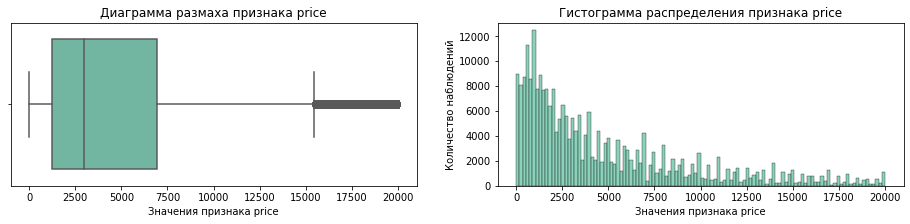

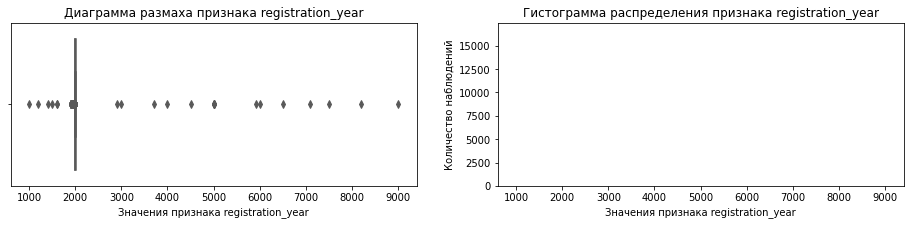

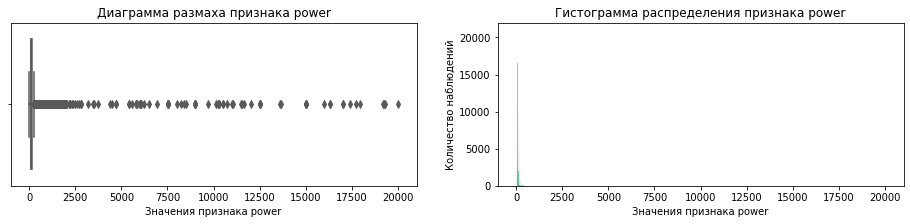

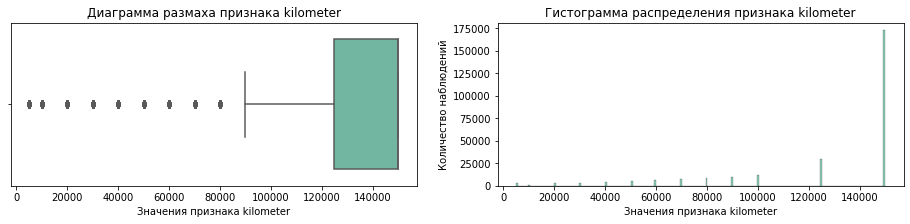

In [36]:
# выведем диаграмму размаха и гистограмму для каждого количественного признака в датасете
# при помощи цикла по количественным признакам
for i, col in enumerate(autos[num_cols]):
    fig = plt.figure(figsize=(16, 3))  # создаем фигуру и задаем параметры графика
    ax1 = fig.add_subplot(1, 2, 1)  # добавляем axes для боксплота
    ax2 = fig.add_subplot(1, 2, 2)  # добавляем axes для гистограммы

    sns.boxplot(data=autos, x=col, ax=ax1) # рисуем боксплот
    sns.histplot(autos[col], ax=ax2) # рисуем гистограмму
    
    # устанавливаем заголовок для боксплота
    ax1.set_title(f'Диаграмма размаха признака {col}')  

    # задаём названия осей для боксплота:
    ax1.set_xlabel(f'Значения признака {col}')
    
    # устанавливаем заголовок для гистограммы
    ax2.set_title(f'Гистограмма распределения признака {col}')  

    # задаём названия осей для гистограммы:
    ax2.set_xlabel(f'Значения признака {col}')
    ax2.set_ylabel('Количество наблюдений')
plt.show()

Основываясь на проведённом анализе, можно сделать следующие выводы:

* **`price` (цена)**: Распределение цены автомобилей похоже на логнормальное, медиана смещена влево, цены на автомобили в выборке сильно варьируются. Большинство автомобилей в выборке стоят не дороже 7500 евро. 

* **`registration_year` (год регистрации)**: большая часть автомобилей зарегистрирована около 2000 года. Однако есть множество отклонений как в левую сторону, так и в правую. Это указывает на то, что данные охватывают широкий диапазон лет регистрации. В них есть аномалии, которые нужно исследовать дополнительно.

* **`power` (мощность)**: множество значений свыше 1000 лошадиных сил. В основном значения признака сконцентрированы недалеко от 0. Среднее значение мощности в выборке составляет 116,6 лошадиных сил, но есть и экстремально высокие значения до 20 000 л. с. Требуется дополнительный анализ этих значений.

* **`kilometer` (пробег)**: данные округлены до десятков и сотен тысяч километров. Большая часть автомобилей имеет пробег свыше 100 000 км. Экземпляров с меньшими пробегами не так много. Ближе от 0 до 20000 км — практически незначительная доля от выборки.

Теперь проанализируем круговые диаграммы для категориальных признаков.

Признаки `brand` и `model` многочисленные, имеют массу вариантов. Их графическое изображение не требуется.

Проанализируем оставшиеся категориальные признаки.

In [37]:
# создаем список с категориальными признаками для построения графиков
cat_cols = ['vehicle_type', 
            'gearbox', 
            'fuel_type',
            'repaired']

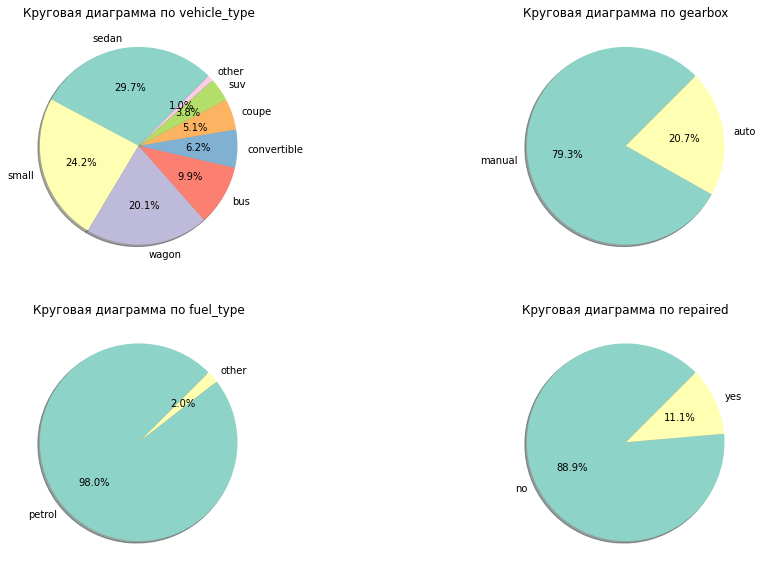

In [38]:
# построим круговую диаграмму
fig = plt.figure(figsize=(16, 10))  # создаем фигуру и задаем параметры графика
# запускаем цикл для каждого признака    
for i, col in enumerate(cat_cols):  # перебираем столбцы
    ax = fig.add_subplot(2, 2, i+1)  # добавляем axes
    # рисуем круговую диаграмму
    autos[col].value_counts().plot.pie(
        legend=False,  # отключаем легенду
        autopct='%1.1f%%',  # указываем формат подписей
        shadow=True,  # включаем тень для диаграммы
        startangle=45,  # устанавливаем начальный угол
        ylabel='',  # убираем метку оси Y
        colors=sns.color_palette('Set3'))  # используем цветовую палитру Set3
    plt.title(f'Круговая диаграмма по {col}')  # подписываем каждый график названием соответствующего признака
plt.show()

**Анализ распределения категориальных признаков**

1. **`vehicle_type` (тип кузова)**: распределение типов кузова показывает, что большинство автомобилей в выборке — седаны (29,7 %). Далее по популярности следуют малые автомобили (24,2 %) и универсалы (20,1 %). Это может быть связано с тем, что эти типы кузовов наиболее распространены среди подержанных автомобилей.

2. **`gearbox` (тип коробки передач)**: подавляющее большинство автомобилей оснащены механической коробкой передач (79,3 %), что также может быть обусловлено популярностью этого типа трансмиссии среди подержанных машин.

3. **`fuel_type` (тип топлива)**: почти все автомобили используют бензин в качестве топлива (98,0 %), что характерно для большинства транспортных средств.

4. **`repaired` (была машина в ремонте или нет)**: большинство автомобилей не были в ремонте (88,9 %), что говорит о хорошем состоянии большинства представленных в выборке машин.

#### Углубленный исследовательский анализ некоторых признаков 

Дополнительно проанализируем значения по тем признакам, распределение которых вызывает вопросы: 
* `registration_year`;
* `power`;
* `kilometer`.

##### Анализ признака  `registration_year`

Если рассуждать логично, то для года регистрации подойдет интервал от конца предыдущего века до года выгрузки базы. 

Год выгрузки базы - 2016 год.

Все прочие значения не могут считаться верными - автомобили будут слишком старыми или их регистрация сделана в будущем, что невозможно.

Итак, посмотрим на гистограмму распределения признака в границах от 1950 до 2016 года.

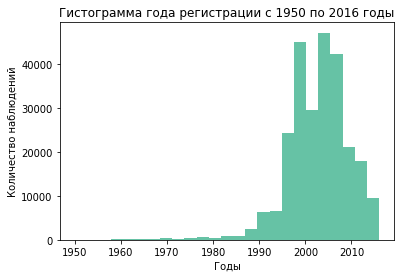

In [39]:
# построим гистограмму распределения признака с границами 1950 и 2016
autos['registration_year'].plot(kind='hist', bins=25, range=(1950, 2016))
plt.title('Гистограмма года регистрации с 1950 по 2016 годы')
plt.xlabel('Годы')
plt.ylabel('Количество наблюдений')
plt.show()

Целесообразно оставить в выборке только значения с 1990 года. Таким автомобилям будет уже около 30 лет, что является почтенным возрастом для автомобиля. 


Автомобили старше этого возраста будем считать уже раритетными, даже если они производились для массового потребления. К таким автомобилям не подойдут закономерности, которые выявит модель прогнозирования цены в ходе обучения на имеющейся у нас выборке.

Тогда распределение признака `registration_year` будет следующим.

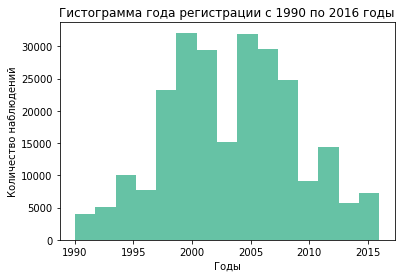

In [40]:
# построим гистограмму распределения признака с границами 1990 и 2016
autos['registration_year'].plot(kind='hist', bins=15, range=(1990, 2016))
plt.title('Гистограмма года регистрации с 1990 по 2016 годы')
plt.xlabel('Годы')
plt.ylabel('Количество наблюдений')
plt.show()

График наглядно демонстрирует, что значительная часть автомобилей, представленных на продажу, была зарегистрирована в середине 2000-х. Однако в выборке преобладают автомобили, которым уже исполнилось 10-15 лет с момента регистрации. При этом заметно меньше экземпляров, выпущенных в 1990-х годах.

In [41]:
# количественно оценим последствия нашего решения
outrange_registration_year = len(autos[~((autos['registration_year'] >= 1990) & (autos['registration_year'] <= 2016))])
print(f'Количество строк в выборке, у которых год регистрации не входит в интервал 1990-2016 гг. : {outrange_registration_year}')
percent_outrange_registration_year = round(outrange_registration_year / len(autos) * 100, 2)
print(f'Доля таких строк в выборке : {percent_outrange_registration_year} %')

Количество строк в выборке, у которых год регистрации не входит в интервал 1990-2016 гг. : 16391
Доля таких строк в выборке : 6.17 %


Удаление аномальных значений года регистрации объективно приведет к повышению качества данных для обучения модели.

При этом из выборки будет удалено около 6 % данных.

##### Анализ признака  `power`

Далее разберемся с признаком `power`.

Минимальная мощность двигателя легкового автомобиля в России, при которой он не считается мопедом или мотоциклом с боковым прицепом, составляет более 50 кВт (около 70 л. с.). Если мощность двигателя меньше 50 кВт, то такой автомобиль считается мотоциклом или мопедом. Это регулируется статьёй 25 Федерального закона «О безопасности дорожного движения». В ней говорится, что для управления автомобилем с двигателем мощностью более 50 кВт (около 70 л. с.), необходимо иметь водительское удостоверение категории B. Если мощность двигателя меньше 50 кВт, то такой автомобиль считается мотоциклом или мопедом.

Тогда *минимальное значение `power` должно быть около 70 л.с.*

Мощность двигателя серийных автомобилей массового производства может варьироваться в широких пределах и зависит от модели и производителя. В среднем максимальная мощность для машин массового рынка составляет примерно от 100 до 300 лошадиных сил. Однако некоторые модели могут иметь более высокую мощность, например, спортивные или премиальные автомобили. Эти виды автомобилей могут иметь более высокую стоимость, чем модели для массового рынка.

Тогда *максимальное значение `power` установим на уровне 300 л.с.*

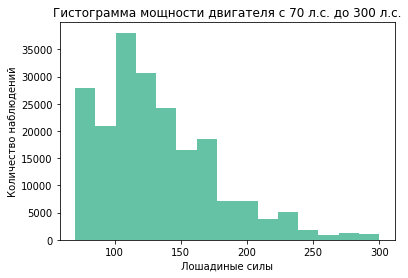

In [42]:
# строим распределение признака в указанных границах - от 70 л.с. до 300 л.с.
autos['power'].plot(kind='hist', bins=15, range=(70, 300))
plt.title('Гистограмма мощности двигателя с 70 л.с. до 300 л.с.')
plt.xlabel('Лошадиные силы')
plt.ylabel('Количество наблюдений')
plt.show()

В основном в данном диапазоне встречаются автомобили, у которых мощность двигателя около 125 л.с., что адекватно отражает реальную картину на дорогах. Автомобилей свыше 250 л.с. совсем мало в данном интервале. 

In [43]:
# количественно оценим последствия нашего решения
outrange_power = len(autos[~((autos['power'] >= 70) & (autos['power'] <= 300))])
print(f'Количество строк в выборке, у которых мощность двигателя не входит в интервал 70-300 л.с. : {outrange_power}')
percent_outrange_power = round(outrange_power / len(autos) * 100, 2)
print(f'Доля таких строк в выборке : {percent_outrange_power} %')

Количество строк в выборке, у которых мощность двигателя не входит в интервал 70-300 л.с. : 60737
Доля таких строк в выборке : 22.85 %


Если на счет верхней границы есть сомнения в том, что она верная, и за ее пределами находятся автомобили с нетипичной для рассматриваемой выборки величиной мощности двигателя, то на счет нижней границы есть четкие законодательные нормы.

Посмотрим какую долю данных мы теряем, если исключаем из выборки объявления с мощностью двигателя, которая не характерна для легковых автомобилей серийного производства (меньше 70 л.с.) 

In [44]:
# количественно оценим последствия нашего решения (теперь исключая только авто с мощностью двигателя меньше 70 л.с.)
less70_power = len(autos[(autos['power'] < 70)])
print(f'Количество строк в выборке, у которых мощность двигателя меньше 70 л.с. : {less70_power}')
perc_less70_power = round(less70_power / len(autos) * 100, 2)
print(f'Доля таких строк в выборке : {perc_less70_power} %')

Количество строк в выборке, у которых мощность двигателя меньше 70 л.с. : 57917
Доля таких строк в выборке : 21.79 %


Как видим, потеря данных обусловлена в большей степени решением исключить из выборки маломощные транспортные средства.

Выбранные ограничения мощности двигателя способствуют повышению степени однородности выборки, но влечет за собой сокращение её объема почти на 23 %. Данное сокращение вызвано объективными причинами, которые мы проанализировали выше. 

##### Анализ признака `kilometer`

Наконец, проанализируем признак `kilometer`.

В результате построения диаграммы размаха и гистограммы мы могли заметить, что данный вид графиков не подходит для формата признака `kilometer`. Судя по характеру данных, для анализа закономерностей распределения признака `kilometer` больше подойдет столбчатая диаграмма. 

Изобразим её ниже на рисунке.

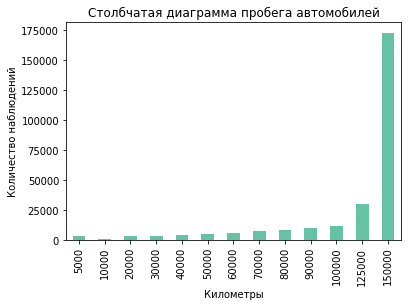

In [45]:
# строим столбчатую диаграмму для значений признака kilometer
autos['kilometer'].value_counts().sort_index().plot(kind='bar')
plt.title('Столбчатая диаграмма пробега автомобилей')
plt.xlabel('Километры')
plt.ylabel('Количество наблюдений')
plt.show()

Из данных можно сделать вывод, что максимальное число наблюдений в выборке соответствует пробегу в 150 тыс. километров. То есть собственники в основном выставляли на продажу автомобили с большим пробегом.

Построив столбчатую диаграмму, мы смогли наглядно и корректно проанализировать распределение значений пробега в выборке. Это позволило нам выявить закономерности распределения данного признака в предоставленных данных.

##### Очистка данных по результатам углубленного исследовательского анализа признаков

На последнем шаге проведения углубленного исследовательского анализа некоторых признаков датасета проведем запланированные преобразования данных, а именно:
- установим интервал для года регистрации - **с 1990 года по 2016 год**;
- определим границы для мощности двигателя - **с 70 л.с. до 300 л.с.**

Перечисленные преобразования помогут повысить качество данных для обучения модели предсказания цены автомобилей и уменьшить степень неоднородности выборки.

In [46]:
autos = autos[(autos['registration_year'] >= 1990) & \
              (autos['registration_year'] <= 2016)]

autos = autos[(autos['power'] >= 70) & (autos['power'] <= 300)]

In [47]:
# выведем долю удаленных значений
print(f'Всего удалено {round(100 - (len(autos) / initial_length * 100),2)} % значений.')

Всего удалено 45.01 % значений.


Итак, на данный момент в результате пройденных этапов подготовки данных мы:
- устранили шесть неинформативных признаков;
- по итогам анализа пропущенных значений удалили 10 % некачественных данных;
- обнаружили дубликаты в данных и удалили их (минус еще около 15 % неактуальных данных); 
- провели исследование распределений отдельных признаков, выявили аномальные значения, в результате чего были удалены еще примерно 18 % данных от изначального объема выборки.

Сокращение датасета на 43 % от изначального объема улучшило качество данных и способствовало повышению однородности выборки, является ключевым фактором для успешного обучения моделей предсказания цены на автомобили. 

### Корреляционный анализ данных

Последний шаг перед обучением моделей - корреляционный анализ данных.

#### Совместное распределение целевого и независимых признаков

Для начала построим совместные распределения целевого признака (`price`) и остальных признаков в датасете.

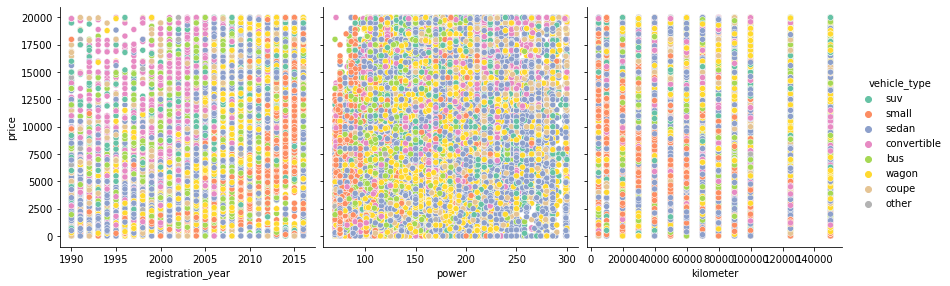

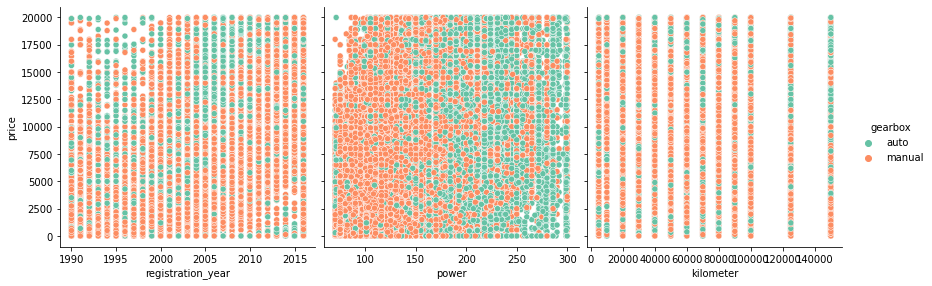

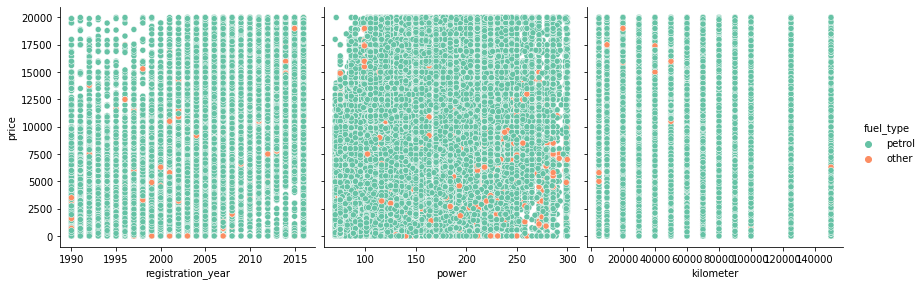

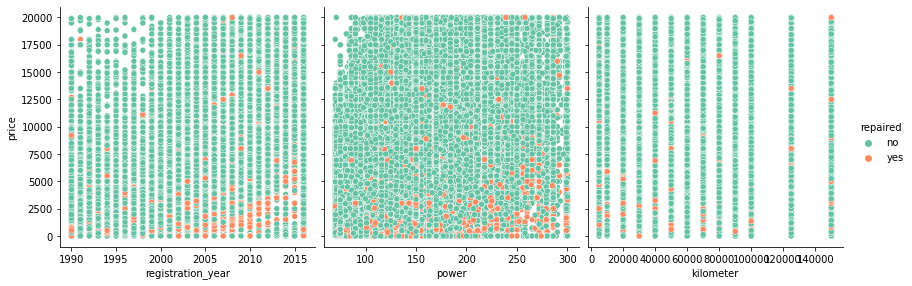

In [48]:
# при помощи цикла изобразим диаграммы рассеяния целевого признака и остальных количественных признаков для каждой категориальной переменной
X_VARS = ['registration_year', 'power', 'kilometer']

for col in cat_cols:
    sns.pairplot(autos, y_vars='price', x_vars=X_VARS, hue=col, height=4, aspect=1)

**Выводы по взаимосвязи признаков:**

1. Существует связь между ценой и типом кузова автомобиля. В частности, автомобили типа sedan представлены в разных ценовых категориях, включая бюджетные и дорогие модели. Это может быть связано с популярностью данного типа кузова среди покупателей.

2. Автомобили типа small в основном представлены моделями 2010–2015 годов выпуска. Чем моложе автомобиль этого типа кузова, тем выше его цена. Прирост цены по сравнению с седанами более существенный.

3. Среди недорогих автомобилей, выпущенных в 1990-х годах, преобладают седаны. А в сегменте дорогих автомобилей тех же лет выпуска больше представлены модели с типами кузова coupe и convertible. Это может указывать на предпочтения покупателей в разные периоды времени.

4. В выборке больше средневозрастных автомобилей (2005 года выпуска) с автоматической коробкой передач. Также в выборке много автомобилей с мощностью двигателя выше 200 л. с., которые оснащены автоматической коробкой передач. Это может указывать на предпочтения покупателей относительно этих характеристик.

5. Мало данных по автомобилям с небензиновым типом топлива, поэтому невозможно сделать выводы о взаимосвязи этого признака с ценой.

6. В основном ремонту подвергались автомобили 2000–2015 годов выпуска. При этом в бюджете до 5000 тысяч евро представлены автомобили разных лет выпуска, включая 1990-е и начало 2000-х. Однако сложно поверить, что автомобили тех лет не ремонтировались перед продажей. Возможно, это связано с особенностями выборки или недостаточной информацией о ремонте в данных.

В целях проведения корреляционного анализа мы выполняем следующие шаги:
1. Создаём корреляционную матрицу, используя коэффициенты корреляции $\phi_K$, поскольку в данных присутствуют как количественные признаки, так и категориальные.
2. Визуализируем её и пронализируем полученные данные.
4. Если будут подозрения на мультиколлинеарность, проверим их при помощи VIF (Variance Inflation Factor).

#### Матрица корреляций

Начинаем с расчета коэффициентов корреляции.

In [49]:
# рассчитаем коэффициенты phi
# считаем корреляции по итоговой таблице с количественными признаками и целевой переменной
autos_phik = autos.phik_matrix(interval_cols=num_cols)

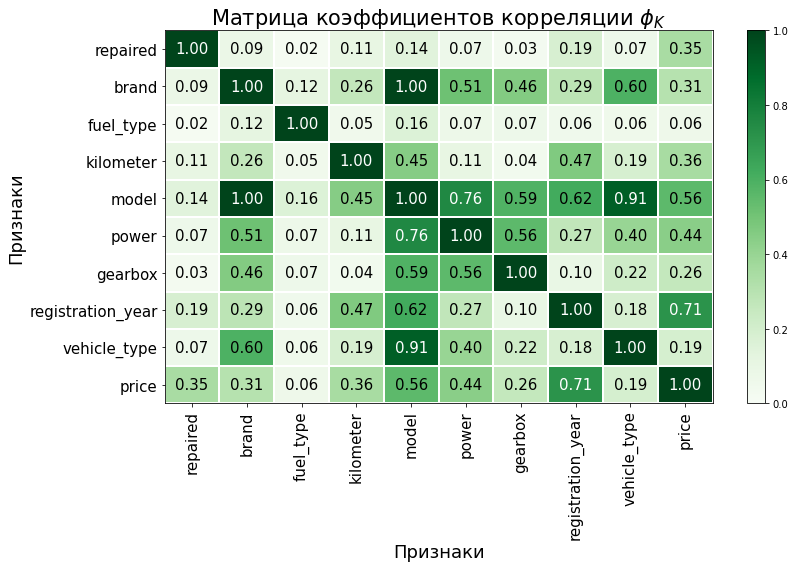

In [50]:
# построим матрицу корреляции
plot_correlation_matrix(
    autos_phik.values, # двумерный массив значений
    x_labels=autos_phik.columns, # названия столбцов матрицы
    y_labels=autos_phik.index, # названия строк матрицы
    vmin=0, # минимальное значение коэффициента корреляции
    vmax=1, # максимальное значение коэффициента корреляции
    color_map='Greens', # цветовая схема для отображения коэффициентов корреляции
    title=r'Матрица коэффициентов корреляции $\phi_K$', # заголовок графика
    x_label='Признаки', # подпись оси X
    y_label='Признаки', # подпись оси Y
    fontsize_factor=1.5, # коэффициент увеличения размера шрифта
    figsize=(12, 8) # размер графика
)

Из матрицы корреляций можно сделать следующие выводы:

1. **Взаимосвязь с целевым признаком price**:
* Цена автомобиля (price) имеет умеренную положительную корреляцию с типом кузова (vehicle_type), моделью (model) и брендом (brand). Это означает, что автомобили определённых типов кузовов, моделей и брендов могут иметь более высокую или низкую стоимость на рынке.
* Также наблюдается слабая положительная корреляция между ценой и пробегом (kilometer), что может быть связано с тем, что более новые автомобили обычно стоят дороже.

2. **Особенности взаимосвязей между остальными признаками**:
* Существует сильная положительная корреляция между типом кузова (vehicle_type) и моделью (model), а также между моделью и брендом (brand), что вполне ожидаемо. Это говорит о том, что определённые модели автомобилей чаще всего выпускаются в определённых типах кузовов и под определёнными брендами.
* Тип коробки передач (gearbox) умеренно положительно коррелирует с моделью автомобиля (model). Это может указывать на то, что некоторые модели чаще оснащаются определённым типом трансмиссии.
* Между пробегом (kilometer) и годом выпуска (registration_year) существует слабая отрицательная корреляция, что логично: чем старше автомобиль, тем больше он проехал километров.

3. **Замечания относительно признака `model`**


Признак `model` может быть удалён из датасета для дальнейшего обучения модели прогнозирования цены по нескольким причинам:


- Признаки `model` и `brand` имеют коэффициент корреляции, равный 1, что указывает на идеальную положительную линейную зависимость между ними. Это означает, что информация о бренде автомобиля полностью определяется его моделью, и наоборот.

- В таблице корреляции признаков видно, что `model` имеет высокую корреляцию с `vehicle_type` (0,91) и `registration_year` (0,62). Это может указывать на то, что информация о модели автомобиля уже содержится в этих признаках, и её удаление не сильно повлияет на качество модели.

- Если модель автомобиля тесно связана с другими признаками, такими как год выпуска или тип транспортного средства, то её удаление может помочь избежать избыточности информации и упростить модель.
 
Удаление признака `model` может помочь модели лучше обобщать данные и делать более точные прогнозы на новых данных, поскольку она будет меньше зависеть от конкретной модели автомобиля.

Эти выводы позволяют лучше понять взаимосвязи между различными признаками в датасете и могут помочь при построении модели для определения рыночной стоимости автомобиля.

**Принятое решение по итогам анализа матрицы корреляции**: считать признак `model` избыточным и удалить его из датасета для устранения мультиколлинеарности.

In [51]:
# удаление признака model
autos = autos.drop('model', axis=1)

На следующем шаге проведем анализ VIF для тестовой выборки.

#### Анализ Variance Inflation Factor

Поскольку часть признаков категориальные, осуществим необходимые преобразования и рассчитаем значения VIF как для количественных переменных, так и для категориальных.

In [52]:
# создаем датафрейм с набором данных для расчета VIF 
autos_vif = autos.assign(const=1) # cоздаём новый столбец const со значением 1

In [53]:
# Для каждого столбца `col` в данных `autos_vif`, который имеет тип данных 'object' (т. е. категориальный),
for col in autos_vif.select_dtypes(include=['object']).columns:
    # создаём экземпляр OneHotEncoder с параметром sparse_output=False, чтобы преобразовать данные в разреженную матрицу,
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    # применяем метод fit_transform к данным `autos_vif` для одного столбца `col`,
    dummy_encoded = encoder.fit_transform(autos_vif[[col]])
    # и заменяем значение столбца `col` на преобразованные данные.
    autos_vif[col] = dummy_encoded

In [54]:
# создадим таблицу с VIF-коэффициентами
# задаем датафрейм
vif_data = pd.DataFrame()

# сохраняем имена признаков из исходной таблицы в таблицу c VIF
vif_data["Признак"] = autos_vif.columns

# рассчитываем VIF-значения для каждого признака
vif_data["VIF"] = [variance_inflation_factor(autos_vif.values, i) for i in range(autos_vif.shape[1])]
  
# выведем таблицу на экран
vif_data

,Признак,VIF
0,price,2.635606
1,vehicle_type,1.028854
2,registration_year,1.863008
3,gearbox,1.213803
4,power,1.681190
5,kilometer,1.457610
6,fuel_type,1.007858
7,brand,1.008477
8,repaired,1.054939
9,const,246462.910412


В нашем случае все значения VIF меньше 5, что говорит об отсутствии сильной мультиколлинеарности между признаками. Это значит, что можно использовать все признаки для построения модели определения рыночной стоимости автомобиля.

### Подготовка моделей разного класса

По условию задачи необходимо построить модель, которая умеет определять рыночную стоимость автомобиля.

Нам необходимо сравнить характеристики моделей: время обучения, время предсказания, точность результата.

Основные моменты при подготовке моделей к обучению:

1. Построение модели для определения рыночной стоимости автомобиля:
Задача включает сравнение характеристик моделей, таких как время обучения, время предсказания и точность результата.

2. Использование библиотеки LightGBM:
Библиотека LightGBM применяется для построения модели градиентного бустинга.

3. Альтернативные модели:
Рассмотрение альтернативных моделей, таких как линейная регрессия и дерево решений.

4. Оптимизация производительности:
Ограничение изменения 2-3 параметров модели градиентного бустинга для оптимизации производительности.

5. Подбор гиперпараметров:
Применение рандомизированного поиска на кросс-валидационной выборке для подбора оптимальных гиперпараметров.

6. Анализ эффективности моделей:
Оценка времени обучения, времени предсказания и качества результатов с использованием метрики RMSE.

7. Проверка качества выбранной модели:
Проверка соответствия выбранной модели критериям заказчика, включая значение метрики RMSE менее 2500 на тестовой выборке.

Начнем с подготовки данных.

In [55]:
# сформируем датасеты с признаками и таргетом
X = autos.drop(['price'], axis=1)  # независимые переменные
y = autos['price']  # целевая переменная

In [56]:
# разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

Создаём два списка с именами столбцов для обработки в пайплайне: ohe_columns для категориальных признаков и num_columns для числовых признаков.

In [57]:
# создаём списки с названиями признаков для обработки в пайплайне
cat_columns = [
    'vehicle_type', 
    'gearbox',
    'fuel_type',
    'brand',
    'repaired'
]
num_columns = [
    'registration_year', 
    'power',
    'kilometer'
]

Создаём пайплайн ohe_pipe для обработки категориальных признаков с помощью OneHotEncoder.

In [58]:
# создаем пайплайн для обработки категориальных признаков (OneHotEncoder)
ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [59]:
# создаем пайплайн для обработки категориальных признаков (OrdinalEncoder)
ord_pipe = Pipeline(
    [
        (
            'ord',
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

Создаём общий пайплайн data_preprocessor для подготовки данных по моделям разного класса.

Код создаёт три общих пайплайна для предварительной обработки данных перед обучением моделей регрессии с использованием различных алгоритмов: Ridge, DecisionTreeRegressor и RandomForestRegressor.

* **data_preprocessor_ridge** использует ColumnTransformer для предварительной обработки данных. 
    Внутри ColumnTransformer определены два преобразования:
    - (‘ohe’, ohe_pipe, cat_columns): применяет OneHotEncoding к категориальным переменным, определённым в списке cat_columns. Это преобразование преобразует категориальные переменные в набор бинарных переменных, где каждая категория представлена отдельным столбцом.
    - (‘num’, StandardScaler(), num_columns): применяет StandardScaler к числовым переменным, определённым в списке num_columns. Это преобразование стандартизирует числовые данные, приводя их к нулевому среднему значению и единичной дисперсии.remainder=‘passthrough’: указывает, что все остальные столбцы должны быть переданы без изменений.
    

* **data_preprocessor_dt** и **data_preprocessor_rf** также используют ColumnTransformer для предварительной обработки данных. Однако в этом случае определено только одно преобразование:
    - (‘ord’, ord_pipe, cat_columns): применяет OrdinalEncoder к категориальным переменным, определённым в списке cat_columns. Это преобразование преобразует категориальные переменные в порядковые переменные, присваивая каждой категории уникальное целое число.
    
    
* **для модели Light_GBM** такого пайплайна не предусмотрено, поскольку в этой модели градиентного бустинга используются собственные кодировщики для явно определенных категориальных признаков. 
    

Эти пайплайны позволяют подготовить данные для обучения моделей регрессии с учётом специфики каждого алгоритма. Например, Ridge требует стандартизации числовых данных, а DecisionTreeRegressor и RandomForestRegressor могут работать с порядковыми данными.

In [60]:
# создаём общий пайплайн подготовки данных для Ridge()
data_preprocessor_ridge = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём общий пайплайн для подготовки данных для DecisionTreeRegressor()
data_preprocessor_dt = ColumnTransformer(
    [
        ('ord', ord_pipe, cat_columns)
    ], 
    remainder='passthrough'
)

# создаём общий пайплайн для подготовки данных для RandomForestRegressor()
data_preprocessor_rf = ColumnTransformer(
    [
        ('ord', ord_pipe, cat_columns)
    ], 
    remainder='passthrough'
)

Поскольку нам важно зафиксировать результаты работы моделей разных классов - формируем четыре пайплайна для машинного обучения. 

Каждый пайплайн состоит из двух основных компонентов:

1. Препроцессор (preprocessor) - это функция или класс, который выполняет предварительную обработку данных.
2. Модель (model) - это алгоритм машинного обучения, который обучается на подготовленных данных и делает предсказания. 

В этом коде используются следующие модели:
- **Ridge()** - линейная регрессия, которая находит прямую линию, наилучшим образом описывающую данные.
- **DecisionTreeRegressor()** - регрессор на основе дерева решений, который разбивает данные на подмножества, чтобы найти наилучшее соответствие.
- **RandomForestRegressor()**: регрессор на основе ансамбля деревьев решений, который повышает точность предсказаний за счёт усреднения результатов нескольких деревьев.
- **LGBMRegressor()** - регрессор на основе Light Gradient Boosting Machine (LGBM), который использует ансамбли деревьев решений для повышения точности предсказаний.

Пайплайны создаются следующим образом:

- **pipe_final_ridge**: объединяет препроцессор data_preprocessor_ridge и модель Ridge().

- **pipe_final_dt**: объединяет препроцессор data_preprocessor_dt и модель DecisionTreeRegressor().

- **pipe_final_rf**: объединяет препроцессор data_preprocessor_rf и модель RandomForestRegressor().

- **pipe_final_lgbm**: объединяет модель LGBMRegressor().


Таким образом, создаются четыре пайплайна для машинного обучения, каждый из которых предназначен для определённой задачи и использует соответствующий препроцессор и модель.

In [127]:
# создаём итоговый пайплайн для Ridge: подготовка данных и модель
pipe_final_ridge = Pipeline([
                            ('preprocessor', data_preprocessor_ridge),
                            ('model', Ridge())
])

# создаём итоговый пайплайн для DecisionTreeRegressor: подготовка данных и модель
pipe_final_dt = Pipeline([
                           ('preprocessor', data_preprocessor_dt),
                           ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# создаём итоговый пайплайн для RandomForestRegressor: подготовка данных и модель
pipe_final_rf = Pipeline([
                            ('preprocessor', data_preprocessor_rf),
                            ('model', RandomForestRegressor(random_state=RANDOM_STATE))
])

# создаём итоговый пайплайн LGBMRegressor: подготовка данных и модель
pipe_final_lgbm = Pipeline([
                            ('model', LGBMRegressor(random_state=RANDOM_STATE))
])

Этот код определяет словари, содержащие параметры для настройки моделей машинного обучения.

* **param_distributions_ridge** — словарь для модели Ridge(). Он содержит два параметра:
    - model__alpha: список значений коэффициента регуляризации α, который контролирует сложность модели. Возможные значения: 1, 0.1, 0.01, 0.001.
    - model__solver: список возможных методов решения задачи оптимизации. Возможные значения: ‘cholesky’, ‘lsqr’, ‘saga’.


* **param_distributions_dt** — словарь для модели DecisionTreeRegressor(). Он содержит два параметра:
    - model__max_depth: диапазон возможных глубин деревьев решений. Значения задаются списком от 5 до 50.
    - model__min_samples_leaf: диапазон минимальных размеров листьев. Значения задаются списком от 2 до 40.


* **param_distributions_rf** — словарь для модели RandomForestRegressor(). В словаре указаны два параметра:
    - model__max_depth: максимальная глубина деревьев. Значения задаются списком от 5 до 50.
    - model__min_samples_leaf: диапазон минимальных размеров листьев. Значения задаются списком от 2 до 40.


* **param_distributions_lgbm** — словарь для модели LGBMRegressor(). Он содержит два параметра:
    - model__n_estimators: список возможных количеств деревьев решений в ансамбле. Возможные значения: 50 и 100.
    - model__num_leaves: диапазон возможных размеров листьев. Значения задаются списком от 2 до 40.


Эти словари используются для настройки гиперпараметров моделей машинного обучения. Они позволяют провести поиск оптимальных параметров для каждой модели, что может улучшить качество и точность предсказаний.

In [124]:
# cловарь для модели Ridge()
param_distributions_ridge = {
    'model__alpha': [1, 0.1, 0.01, 0.001], 
    'model__solver': ['cholesky', 'lsqr','saga']
}
 
# словарь для модели DecisionTreeRegressor()
param_distributions_dt = {
        'model__max_depth': range(5, 200),
        'model__min_samples_leaf': range(2, 40)
}

# словарь для модели RandomForest()
param_distributions_rf = {
    'model__max_depth': range(5, 200),
    'model__min_samples_leaf': range(2, 40)
}

# словарь для модели LGBMRegressor()
param_distributions_lgbm = {
        'model__n_estimators': [50, 100],
        'model__num_leaves': range(2, 40)
}

Далее создадим функцию, которая выполняет следующие шаги:
1. **Поиск лучшей модели**:
* Активирует поиск лучшей модели с помощью RandomizedSearchCV, передавая pipe_final и param_distributions в качестве аргументов.
* Выполняет поиск лучшей модели на обучающей выборке.
2. **Оценка модели**:
* Измеряет время обучения и тестирования модели, используя timeit.default_timer().
* Вычисляет среднеквадратичную ошибку на обучающей выборке (train_rmse) и возвращает лучшие параметры модели (randomized_search.best_params_).
* Создаёт фрейм данных model_results с результатами обучения и тестирования модели.
3. **Предсказание**:
* Использует лучшую модель для предсказания значений целевой переменной на тестовой выборке.
4. **Возврат результатов**:
* Возвращает лучшую модель, её параметры, результаты обучения и предсказанные значения.

Помимо замера времени обучения и предсказания, сравним модели по среднему времени обучения одной модели.

Наш метод замера подразумевает измерение времени от начала рандомизированного поиска и оценки параметров кросс-валидационной выборки до конца этой процедуры. С учетом того, что мы используем выборочный поиск с ограничением подбора гиперпараметров в 10 итераций, а кросс-валидацию будем проводить по 5 выборкам, максимально получим 50 оценок моделей. Но минимального порога у нас нет, поэтому если количество итераций будет меньше (по причине малого диапазона гиперпараметров для перебора), то сравнивать скорость обучения корректнее по средней продолжительности, а не по общей.

Значит отдельно будем сохранять в выводе функции метрику ***mean_fit_time***, которая автоматически рассчитывается в RandomizedSearchCV.

In [112]:
# запишем функцию для обучения моделей
def model_pred(pipe_final, param_distributions):
    
    # активируем поиск лучшей модели 
    randomized_search = RandomizedSearchCV(pipe_final, 
                                           param_distributions, 
                                           cv=5,
                                           scoring='neg_root_mean_squared_error',
                                           random_state=RANDOM_STATE,
                                           n_jobs=-1,
                                           verbose=3)
    
    # осуществляем рандимизированный поиск и замеряем время обучения
    start_train_time = timeit.default_timer()  # отмечаем старт обучения
    
    # функция проверяет, является ли объект экземпляром указанного класса 
    if isinstance(pipe_final['model'], LGBMRegressor):
        X_train[cat_columns] = X_train[cat_columns].astype('category') # преобразуем тип категориальных признаков для LGBMRegressor
        randomized_search.fit(X_train, y_train)    # подбираем лучшую модель
    else:   
        randomized_search.fit(X_train, y_train)    # подбираем лучшую модель
    
    end_train_time = timeit.default_timer()    # отмечаем конец обучения
    train_time = end_train_time - start_train_time # рассчитываем продолжительность подбора параметров
    
    # предсказываем значения на тестовой выборке и замеряем время предсказания
    start_test_time = timeit.default_timer()  # отмечаем старт предсказания
    
    # функция проверяет, является ли объект экземпляром указанного класса 
    if isinstance(pipe_final['model'], LGBMRegressor):
        X_test[cat_columns] = X_test[cat_columns].astype('category') # преобразуем тип категориальных признаков для LGBMRegressor
        pred = randomized_search.predict(X_test)    # по лучшей модели делаем прогноз
    else:   
        pred = randomized_search.predict(X_test)  # по лучшей модели делаем прогноз
    
    end_test_time = timeit.default_timer()    # отмечаем конец предсказания
    test_time = end_test_time - start_test_time # рассчитываем продолжительность предсказания
    
    # сохраняем модуль rmse 
    train_rmse = abs(randomized_search.best_score_)
    
    # формируем переменную со средним временем, затраченным на обучение моделей 
    cv_results = pd.DataFrame(randomized_search.cv_results_)
    first_model_idx = cv_results.loc[cv_results['rank_test_score']==1,'mean_fit_time'].index.item()
    mean_fit_time = cv_results.loc[first_model_idx,'mean_fit_time']
    
    # записываем ключевые метрики в датафрейм
    model_results = pd.DataFrame({'train_rmse': [train_rmse],
                                  'train_time': [train_time],
                                  'test_time': [test_time],
                                  'mean_fit_time': [mean_fit_time]})
    
    # функция вернет лучшую модель, её параметры, ключевые метрики и предсказания
    return  randomized_search.best_estimator_, \
            randomized_search.best_params_, \
            model_results, \
            pred

Итак, мы совершили все необходимые шаги на пути обучения моделей.

В процессе подготовки к обучению модели для определения рыночной стоимости автомобиля были учтены различные требования и примечания к задаче, а именно:
- обучение нескольких моделей,
- использование библиотеки LightGBM, 
- критерии для альтернативных моделей (более простые модели), 
- необходимость подбора гиперпараметров, 
- критерии для анализа эффективности моделей и проверки качества выбранной модели.

Для решения задачи были созданы три пайплайна машинного обучения, каждый из которых включал препроцессор и модель. В качестве моделей использовались:
- Ridge для линейной регрессии, 
- DecisionTreeRegressor на основе дерева решений,
- RandomForestRegressor на основе ансамблей решающих деревьев,
- LGBMRegressor на основе Light Gradient Boosting Machine.

Для настройки гиперпараметров моделей были созданы соответствующие словари: 
- param_distributions_ridge для Ridge, 
- param_distributions_dt для DecisionTreeRegressor,
- param_distributions_rf для RandomForestRegressor,
- param_distributions_lgbm для LGBMRegressor. 

Эти словари позволяют варьировать параметры моделей для оптимизации производительности и повышения точности прогнозирования.


Функция, созданная для выполнения поиска лучшей модели, оценки её производительности и предсказания значений целевой переменной на тестовой выборке, позволяет автоматизировать процесс обучения и тестирования моделей.

В процессе первого этапа исследовния была проведена подготовка данных и были достигнуты следующие результаты:
1) **Предобработка данных**:
- Устранены шесть неинформативных признаков.
- Удалены 10% некачественных данных с пропущенными значениями.
- Обнаружены и удалены дубликаты данных (около 15% неактуальных данных).
- Исследованы распределения отдельных признаков и удалены аномальные значения (примерно 21% данных от изначального объёма выборки).


2) **Анализ корреляций**:
- Выявлены умеренная положительная корреляция между ценой автомобиля и типом кузова, моделью и брендом, а также слабая положительная корреляция между ценой и пробегом.
- Установлена сильная положительная корреляция между типом кузова и моделью, а также между моделью и брендом. Определена умеренная положительная корреляция между типом коробки передач и моделью автомобиля. Признак `model` удален из-за тесной взаимосвязи с другими признаками.
- Обнаружена слабая отрицательная корреляция между пробегом и годом выпуска.


3) **Подготовка к обучению моделей**:
- Созданы три пайплайна машинного обучения, включающие препроцессор и модель.
- Использованы модели Ridge для линейной регрессии, DecisionTreeRegressor, RandomForestRegressor на основе деревьев решений  и LGBMRegressor на основе Light Gradient Boosting Machine.
- Настроены гиперпараметры моделей с помощью соответствующих словарей.
- Разработана функция для поиска лучшей модели, оценки её производительности и предсказания значений целевой переменной на тестовой выборке. Это позволяет автоматизировать процесс обучения и тестирования моделей, что значительно упрощает и ускоряет работу над задачей определения рыночной стоимости автомобиля.

## Обучение моделей

Далее приступим к обучению моделей.

In [113]:
# сохраняем результаты работы функции для линейной модели
best_estimator_ridge, best_params_ridge, model_results_ridge, pred_ridge = model_pred(pipe_final_ridge, param_distributions_ridge)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END model__alpha=0.001, model__solver=lsqr;, score=-2726.987 total time=   3.2s
[CV 2/5] END model__alpha=0.001, model__solver=lsqr;, score=-2733.936 total time=   3.8s
[CV 3/5] END model__alpha=0.001, model__solver=lsqr;, score=-2713.589 total time=   3.3s
[CV 4/5] END model__alpha=0.001, model__solver=lsqr;, score=-2708.535 total time=   3.4s
[CV 5/5] END model__alpha=0.001, model__solver=lsqr;, score=-2718.468 total time=   3.4s
[CV 1/5] END model__alpha=0.1, model__solver=saga;, score=-2726.772 total time=   3.0s
[CV 2/5] END model__alpha=0.1, model__solver=saga;, score=-2734.079 total time=   3.0s
[CV 3/5] END model__alpha=0.1, model__solver=saga;, score=-2713.547 total time=   2.9s
[CV 4/5] END model__alpha=0.1, model__solver=saga;, score=-2708.062 total time=   2.8s
[CV 5/5] END model__alpha=0.1, model__solver=saga;, score=-2718.449 total time=   2.8s
[CV 1/5] END model__alpha=0.001, model__solver=cholesky;, s

In [114]:
# сохраняем результаты работы функции для дерева решений
best_estimator_dt, best_params_dt, model_results_dt, pred_dt = model_pred(pipe_final_dt, param_distributions_dt)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END model__max_depth=49, model__min_samples_leaf=21;, score=-2005.969 total time=   0.5s
[CV 2/5] END model__max_depth=49, model__min_samples_leaf=21;, score=-2017.120 total time=   0.4s
[CV 3/5] END model__max_depth=49, model__min_samples_leaf=21;, score=-1973.221 total time=   0.4s
[CV 4/5] END model__max_depth=49, model__min_samples_leaf=21;, score=-1964.441 total time=   0.4s
[CV 5/5] END model__max_depth=49, model__min_samples_leaf=21;, score=-1995.211 total time=   0.4s
[CV 1/5] END model__max_depth=42, model__min_samples_leaf=10;, score=-1993.032 total time=   0.4s
[CV 2/5] END model__max_depth=42, model__min_samples_leaf=10;, score=-1996.244 total time=   0.4s
[CV 3/5] END model__max_depth=42, model__min_samples_leaf=10;, score=-1959.020 total time=   0.4s
[CV 4/5] END model__max_depth=42, model__min_samples_leaf=10;, score=-1945.557 total time=   0.4s
[CV 5/5] END model__max_depth=42, model__min_samples_leaf

In [125]:
# сохраняем результаты работы функции для случайного леса
best_estimator_rf, best_params_rf, model_results_rf, pred_rf = model_pred(pipe_final_rf, param_distributions_rf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END model__max_depth=161, model__min_samples_leaf=37;, score=-1989.868 total time=  14.3s
[CV 2/5] END model__max_depth=161, model__min_samples_leaf=37;, score=-1995.761 total time=  13.4s
[CV 3/5] END model__max_depth=161, model__min_samples_leaf=37;, score=-1967.016 total time=  13.5s
[CV 4/5] END model__max_depth=161, model__min_samples_leaf=37;, score=-1967.017 total time=  13.8s
[CV 5/5] END model__max_depth=161, model__min_samples_leaf=37;, score=-1976.413 total time=  13.4s
[CV 1/5] END model__max_depth=157, model__min_samples_leaf=13;, score=-1902.276 total time=  15.1s
[CV 2/5] END model__max_depth=157, model__min_samples_leaf=13;, score=-1913.659 total time=  15.0s
[CV 3/5] END model__max_depth=157, model__min_samples_leaf=13;, score=-1873.140 total time=  15.2s
[CV 4/5] END model__max_depth=157, model__min_samples_leaf=13;, score=-1873.683 total time=  15.3s
[CV 5/5] END model__max_depth=157, model__min_sa

In [126]:
# сохраняем результаты работы функции для light_gbm
best_estimator_lgbm, best_params_lgbm, model_results_lgbm, pred_lgbm = model_pred(pipe_final_lgbm, param_distributions_lgbm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END model__n_estimators=50, model__num_leaves=25;, score=-1890.263 total time=   1.7s
[CV 2/5] END model__n_estimators=50, model__num_leaves=25;, score=-1903.388 total time=   2.2s
[CV 3/5] END model__n_estimators=50, model__num_leaves=25;, score=-1873.336 total time=   1.7s
[CV 4/5] END model__n_estimators=50, model__num_leaves=25;, score=-1862.600 total time=   1.9s
[CV 5/5] END model__n_estimators=50, model__num_leaves=25;, score=-1887.587 total time=   1.9s
[CV 1/5] END model__n_estimators=50, model__num_leaves=19;, score=-1916.012 total time=   1.6s
[CV 2/5] END model__n_estimators=50, model__num_leaves=19;, score=-1925.269 total time=   1.6s
[CV 3/5] END model__n_estimators=50, model__num_leaves=19;, score=-1898.097 total time=   1.6s
[CV 4/5] END model__n_estimators=50, model__num_leaves=19;, score=-1888.088 total time=   1.6s
[CV 5/5] END model__n_estimators=50, model__num_leaves=19;, score=-1906.038 total ti

Модели обучены. Проанализируем результаты.

## Анализ моделей

Объединим результаты работы функции обучения моделей по каждому из классов в одну таблицу.

In [128]:
# объединим результаты обучения трех моделей
model_comparison = pd.concat([model_results_ridge, 
                              model_results_dt, 
                              model_results_rf, 
                              model_results_lgbm])
model_comparison.index = ['linear_ridge', 
                          'decision_tree', 
                          'random_forest', 
                          'light_gbm']

# выведем общую таблицу на экран
model_comparison.round(2)

,train_rmse,train_time,test_time,mean_fit_time
linear_ridge,2720.18,124.51,0.26,0.48
decision_tree,1972.23,20.85,0.06,0.39
random_forest,1837.91,776.29,1.19,17.20
light_gbm,1850.18,95.06,0.50,2.80


Из новой таблицы видно, что модель **LightGBM** показывает лучшее качество обучения (`train_rmse`), что говорит о её способности точнее предсказывать цены на основе предоставленных данных. Однако, несмотря на это преимущество, время обучения этой модели (`train_time`) значительно больше, чем у других моделей, что может указывать на сложность и ресурсоёмкость процесса обучения.

Также стоит отметить, что среднее время обучения лучшей модели (`mean_fit_time`) также достаточно велико для **LightGBM**, что может быть связано с особенностями алгоритма и объёмом данных, используемых для обучения.

Модель **Decision Tree** показывает хорошее соотношение между качеством обучения и временем обучения, что делает её хорошим выбором для задач, где требуется баланс между точностью предсказаний и скоростью обучения.

**Random Forest** и **Linear Ridge** также показывают хорошие результаты, но их качество обучения немного уступает **LightGBM** и **Decision Tree**.

Оказалось, что среднее время обучения одной модели подчиняется тем же закономерностям, что и общее время рандомизированного поиска.

Выведем информацию о лучшей модели согласно критериям заказчика.

Будем учитывать условия:
- RMSE меньше 2500;
- время на обучение и время на предсказание минимальное.

Отфильтруем датафрейм по `train_rmse` и `train_time`.

In [150]:
# фильтрация и сортировка model_comparison по критериям заказчика
filtered_model_comparison = model_comparison.query('train_rmse < 2500')
print('Рейтинг моделей, подходящих под критерии заказчика:')
rating_models = filtered_model_comparison.sort_values(by="train_time").round(2)
print(rating_models)

Рейтинг моделей, подходящих под критерии заказчика:
               train_rmse  train_time  test_time  mean_fit_time
decision_tree     1972.23       20.85       0.06           0.39
light_gbm         1850.18       95.06       0.50           2.80
random_forest     1837.91      776.29       1.19          17.20


Исходя из рейтинга по времени обучения, лучшей моделью для определения рыночной стоимости автомобиля является ***decision_tree***. Эта модель обеспечивает хорошее соотношение точности предсказаний (`train_rmse` менее 2500) и минимального времени на обучение. Однако из всех представленных моделей она наименнее точна.

Модель **LightGBM** является лучшей моделью для данной задачи, поскольку она удовлетворяет обоим критериям заказчика:

- ***RMSE меньше 2500***: 
    * Значение RMSE для модели LightGBM составляет 1850.18, что меньше заданного порога в 2500. Это указывает на высокую точность предсказаний модели.


- ***Минимальное время на обучение и предсказание***: 
    * Хотя время на обучение (train_time) для LightGBM составляет 95.06, это всё ещё одно из наименьших значений среди всех моделей. Это означает, что модель LightGBM способна обучаться быстрее, чем другие модели.
    * Кроме того, среднее время обучения (mean_fit_time) для LightGBM составляет 2.80, что также является одним из наименьших значений среди всех моделей. Это указывает на эффективность и быстроту процесса обучения модели.

Таким образом, модель **LightGBM** является оптимальным выбором для данной задачи, так как она обеспечивает высокую точность предсказаний при относительно небольшом времени на обучение и предсказание.

Посмотрим о какой именно модели идет речь.

In [147]:
# выведем на экран best_estimator_lgbm
best_estimator_lgbm

Pipeline(steps=[('model', LGBMRegressor(num_leaves=20, random_state=12))])

In [146]:
# выведем параметры лучшей модели
best_params_lgbm

{'model__num_leaves': 20, 'model__n_estimators': 100}

*Выводы о лучшей модели*

Лучшая модель для определения рыночной стоимости автомобиля — это модель на Light GBM. Она обеспечивает хорошее соотношение точности предсказаний и времени на обучение.

*Параметры лучшей модели:*
* num_leaves = 20;
* n_estimators = 100.

Эти параметры указывают на то, что модель использует глубокое дерево решений с относительно небольшим количеством листьев. Это позволяет модели быть достаточно гибкой, чтобы адаптироваться к сложным зависимостям в данных, но при этом достаточно простой, чтобы избежать переобучения.

Мы проанализировали время обучения, время предсказания и качество моделей.
Опираясь на критерии заказчика, выбрали лучшую модель, 

Следующий наш шаг - проверить качество выбранной лучшей модели на тестовой выборке.

In [156]:
# рассчитаем rmse лучшей модели на тестовой выборке
test_rmse = mean_squared_error(y_test, pred_lgbm, squared=False)

In [171]:
# вывод финальных результатов
print("\nРезультаты:")
print("Лучшая модель: Light GBM")
print("Параметры лучшей модели", best_params_lgbm)
print("Качество предсказания на тестовой выборке:", round(test_rmse,2))
print("Время предсказания на тестовой выборке:", round(filtered_model_comparison.loc['light_gbm','test_time'],2))


Результаты:
Лучшая модель: Light GBM
Параметры лучшей модели {'model__num_leaves': 20, 'model__n_estimators': 100}
Качество предсказания на тестовой выборке: 1850.89
Время предсказания на тестовой выборке: 0.5


В рамках проекта по разработке нового приложения для сервиса по продаже автомобилей с пробегом «Не бит, не крашен» была поставлена цель создать модель машинного обучения, способную быстро и точно предсказывать рыночную стоимость автомобиля на основе его характеристик.

Для достижения этой цели были выполнены следующие задачи:

1. Изучены данные о характеристиках автомобилей, выявлены аномалии и пропущенные значения.
2. Обработаны данные, включая заполнение пропущенных значений и удаление аномалий.
3. Подготовлены выборки для обучения моделей, включая разделение данных на тренировочную и тестовую выборки.
4. Обучены различные модели машинного обучения, включая LightGBM и другие модели, не использующие бустинг.
5. Проанализированы время обучения, время предсказания и качество моделей.
6. Выбрана лучшая модель на основе критериев заказчика, включая качество предсказания, время обучения и время предсказания.
7. Проверено качество выбранной модели на тестовой выборке.

Критерии заказчика включают качество предсказания, время обучения модели и время предсказания модели. Для оценки качества моделей используется метрика RMSE, значение которой должно быть меньше 2500.

Данные содержат информацию о различных признаках автомобилей, таких как тип кузова, год регистрации, тип коробки передач, мощность, модель, пробег, тип топлива, марка автомобиля, был ли автомобиль в ремонте. Целевым признаком является цена автомобиля в евро.


На основании проведённого анализа моделей для предсказания рыночной стоимости автомобиля, можно сделать следующие общие выводы:

**Качество предсказания:** 
* Модель LightGBM показала оптимальное качество предсказания среди всех рассмотренных моделей, имея один из наименьших показателей RMSE. Это указывает на её способность точно предсказывать цены на автомобили на основе предоставленных данных.

**Время обучения и предсказания:** 
* Модель LightGBM является наилучшим сочетанием качества и времени для обучения и предсказания. В условиях, когда время является критическим фактором, такой выбор можно считать единственно верным.

**Выбор модели:** 
* Выбор между моделями зависит от конкретных требований и ограничений проекта. Если требуется высокая точность предсказаний и есть возможность подождать дольше для обучения модели, LightGBM может быть хорошим выбором. Однако, если время обучения и предсказания критично, можно рассмотреть модели Random Forest или Decision Tree, которая показали хорошие результаты с точки зрения времени работы. Однако по сравнению с Light GBM модель Random Forest существенно дольше обучается, а Decision Tree - менее точна.

**Ограничения исследования**
* Ограничением данного исследования является то, что обучение моделей проводилось с использованием рандомизированного поиска с кросс-валидацией, а не по сетке (grid search), что не позволило учесть все возможные комбинации гиперпараметров моделей. Это означает, что полученные результаты могут быть улучшены путём использования более полного перебора параметров, хотя это может потребовать значительных вычислительных ресурсов и времени.

**Рекомендации:** 
* Рекомендуется провести более детальный анализ и тестирование на различных наборах данных, чтобы выбрать наиболее подходящую модель для конкретного случая. Также стоит учесть, что результаты могут варьироваться в зависимости от конкретных условий и настроек моделей.